# Background

The COVID-19 pandemic has taken a devastating toll on the restaurant industry. Many states imposed strict lockdown measures to contain the deadly virus. During this unprecedented lockdown period across America, more than 110,000 eating and drinking establishments closed either temporarily or for good. Among the permanently closed restaurants, a majority of them were well-established businesses and fixtures in their communities that had been in the business for 16 years on average. 

New York City's Chinatown was hit hard once news broke about the coronavirus outbreak in Wuhan, China in early 2020. Restaurant sales dropped due to the fears of deadly COVID-19 virus on top of travel restrictions. Now, a year into the COVID-19 pandemic, Chinese restaurants are still struggling with race-related attacks as anti-Asian and xenophobic sentiment swept the nation.

As a New Yorker I want to support our local Chinese businesses by highlighting the best establishments in your local borough. Or, if you are a tourist, where to go get great Chinese food. Or, on the flip side, help business owners who are considering opening a new restaurant or moving the current restaurant due to hardship to find the optimal location based on target demographics.

source:
1. https://restaurant.org/news/pressroom/press-releases/restaurant-industry-in-free-fall-10000-close-in
2. https://www.cdc.gov/mmwr/volumes/69/wr/mm6946a2.htm
3. https://thenycalliance.org/information/december-2020-rent-report


# Problem

1. Where can you go in NYC to have the best Chinese food?
2. Which neighborhood can you go in the borough you live to find the best Chinese food?
3. Which neighborhood in NYC will be the best choice to open a new Chinese restaurant?


# Data

Source 1: https://cocl.us/new_york_dataset \
This dataset contains NYC neighborhoods, boroughs, latitudes and longitudes

Source 2: FourSquare data that contains venue details- venue name, venue id, latitudes and longitudes,boroughs, neighborhoods and ratings\

Source 3: https://www1.nyc.gov/site/doh/data/data-sets/epi-census.page \
Census data 2010 contains NYC neighborhoods, population and race/ethnicity

Source 1 and source 2 data will be used to resolve problem one and two. All sources added up together will be used to resolve problem 3.


In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

from bs4 import BeautifulSoup # for scrapping
from urllib.request import urlopen

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library
import matplotlib.pyplot as plt

#### Define a function to get NYC neighborhood data

In [2]:
def get_nyc_data():
    # define the corresponding url
    url = 'https://cocl.us/new_york_dataset'
    # send the Get request
    r = requests.get(url).json()
    # all the relevant data is in the features key
    features = r['features']
    
    # transform nested python dic into pandas dataframe
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    nyc_data = pd.DataFrame(columns=column_names)
    
    # loop through the data and fill the dataframe one row at a time
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        nyc_data = nyc_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return nyc_data

In [3]:
nyc_data = get_nyc_data()
print(len(nyc_data['Borough'].unique()),nyc_data.shape[0])
print(nyc_data.shape)

5 306
(306, 4)


In [4]:
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


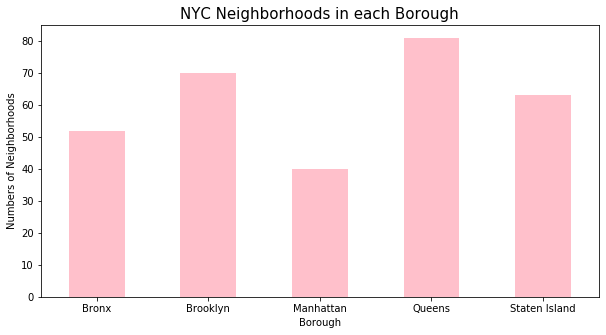

In [5]:
nyc_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color ='pink')
plt.title('NYC Neighborhoods in each Borough',fontsize = 15)
plt.xlabel('Borough')
plt.ylabel('Numbers of Neighborhoods')
plt.xticks(rotation = 'horizontal')
plt.show()

In [6]:
nyc_data.groupby('Borough')['Neighborhood'].count().sort_values(ascending=False)

Borough
Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Neighborhood, dtype: int64

#### Define a function that use geopy library to get the latitude and longitude values

In [7]:
def get_geo_locations(address):
    # In order to define an instance of the geocoder,user_agent needs to be defined
    geolocator = Nominatim(user_agent="nyc_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude
print(get_geo_locations('New York City, NY'))

(40.7127281, -74.0060152)


#### Define a function that takes the return of get_geo_locations(address) to create a dataframe that returns top 100 venues in a given geo locations

In [8]:
# Define Foursquare credentials and version
CLIENT_ID = 'CG305P0BCWY5OXLGUGVMIKKWQFSOZE3GVD2XOPL5BJYCYNGR'  #Foursquare ID
CLIENT_SECRET = '3PGYL1SK4VPMNAFBVK3YZ2Z3QYXYTY2E0U3RQCMVXWLKP5OJ' #Foursquare Secret
VERSION = '20180605'
LIMIT = 100 #limit of number of venues returned by Foursquare API

In [9]:
def get_venues(lat,lng,radius = 500):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # make the GET request
    results = requests.get(url).json()
    data = results["response"]['groups'][0]['items']
    # return only relevant information
    venues = []
    for row in data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_lat = row['venue']['location']['lat']
            venue_lng = row['venue']['location']['lng']
            venue_category=row['venue']['categories'][0]['name']
            venues.append([venue_id,venue_name,venue_lat,venue_lng,venue_category])
        except KeyError:
            pass
    column_names=['Id','Name','Lat','Lng','Category']
    df = pd.DataFrame(venues,columns=column_names)
    return df


In [10]:
get_venues(nyc_data['Latitude'][0],nyc_data['Longitude'][0])

,Id,Name,Lat,Lng,Category
0,4c537892fd2ea593cb077a28,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,4d6af9426107f04dedeb297a,Rite Aid,40.896649,-73.844846,Pharmacy
2,4c783cef3badb1f7e4244b54,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,5d5f5044d0ae1c0008f043c3,Walgreens,40.896528,-73.844700,Pharmacy
4,4d33665fb6093704b80001e0,Subway,40.890468,-73.849152,Sandwich Place
5,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant,40.898083,-73.850259,Caribbean Restaurant
6,4c25c212f1272d7f836385c5,Dunkin',40.890459,-73.849089,Donut Shop
7,4f32458019836c91c7c734ff,Central Deli,40.896728,-73.844387,Deli / Bodega
8,5681717c498e9b9cf4d8c187,Koss Quick Wash,40.891281,-73.849904,Laundromat


#### Define a function that takes the venue id to get venue rating. We only need rating since it cludes the evaluation of tips and likes.
Foursqaure definition: https://support.foursquare.com/hc/en-us/articles/201109274-Place-ratings

##### " Place ratings

A place’s rating is based on a number of signals that we’ve gathered from our social data mines; likes and dislikes, and positive versus negative tips. Not all pages will have ratings – sometimes this is because of the type of place, and other times, we haven’t gathered enough information to give you an educated rating just yet. So when you like/dislike a business or leave a tip, you're actively contributing to that score! 
"


In [11]:
def get_venue_details(venue_id):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # make the GET request
    results = requests.get(url).json()
    print(results['meta'])
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_rating=venue_data['rating']
        venue_details.append([venue_id,venue_name,venue_rating])
    except KeyError:
        pass
    column_names=['Id','Name','Rating']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [12]:
get_venue_details('4c537892fd2ea593cb077a28')

{'code': 200, 'requestId': '6058ffc7c87eac3681843d14'}


,Id,Name,Rating
0,4c537892fd2ea593cb077a28,Lollipops Gelato,8.9


In [13]:
print(list(get_venue_details('4c537892fd2ea593cb077a28').columns))

{'code': 200, 'requestId': '6058ffc989267750fdaad2b3'}
['Id', 'Name', 'Rating']


In [14]:
print(list(nyc_data.columns.values))

['Borough', 'Neighborhood', 'Latitude', 'Longitude']


In [15]:
# define the dataframe columns
column_names = list(nyc_data.columns.values) 
# instantiate the dataframe
chi_rest_nyc = pd.DataFrame(columns=column_names)

In [16]:
count = 1
for Borough, Neighborhood, Latitude, Longitude in nyc_data.values.tolist():
    venues = get_venues(Latitude,Longitude)
    chi_rest = venues[venues['Category']=='Chinese Restaurant']   
    for id, name , lat, lng, category in chi_rest.values.tolist():
        chi_rest_nyc = chi_rest_nyc.append({'Borough': Borough,
                             'Neighborhood': Neighborhood, 
                             'Latitude': lat,
                             'Longitude':lng,
                             'ID': id,
                             'Name' : name}, ignore_index=True)
    count+=1


In [17]:
chi_rest_nyc.to_csv('chinese_restaurant_NYC.csv')

In [18]:
chi_rest_nyc = pd.read_csv('chinese_restaurant_NYC.csv', index_col=[0])

In [19]:
chi_rest_nyc.shape

(216, 6)

In [20]:
chi_rest_nyc.head()

,Borough,Neighborhood,Latitude,Longitude,ID,Name
0,Bronx,Eastchester,40.888785,-73.831226,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
1,Bronx,Kingsbridge,40.883705,-73.897896,4e3b11c98877b00cfc27a483,Guan Hin Restaurant
2,Bronx,Norwood,40.879876,-73.876629,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
3,Bronx,Pelham Parkway,40.855790,-73.855455,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
4,Bronx,Pelham Parkway,40.855168,-73.855587,4bc8f646b6c49c74d8898d91,Great Wall Chinese Restaurant


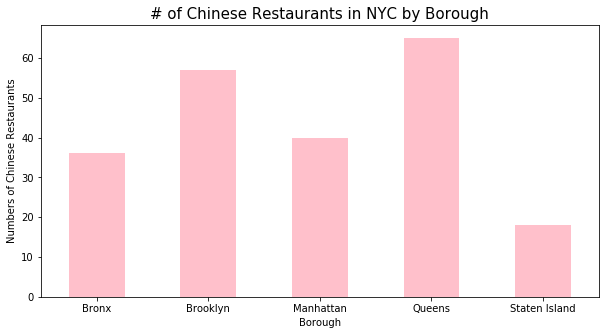

Borough
Queens           65
Brooklyn         57
Manhattan        40
Bronx            36
Staten Island    18
Name: ID, dtype: int64


In [21]:
chi_rest_nyc.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color ='pink')
plt.title('# of Chinese Restaurants in NYC by Borough',fontsize = 15)
plt.xlabel('Borough')
plt.ylabel('Numbers of Chinese Restaurants')
plt.xticks(rotation = 'horizontal')
plt.show()
print(chi_rest_nyc.groupby('Borough')['ID'].count().sort_values(ascending=False))

In [22]:
chi_rest_nyc.groupby('Neighborhood')['ID'].count().sort_values(ascending=False)

Neighborhood
Chinatown         8
Bedford Park      4
High  Bridge      4
Bensonhurst       4
Kew Gardens       4
                 ..
Parkchester       1
Pelham Bay        1
Pelham Gardens    1
Pomonok           1
Allerton          1
Name: ID, Length: 127, dtype: int64

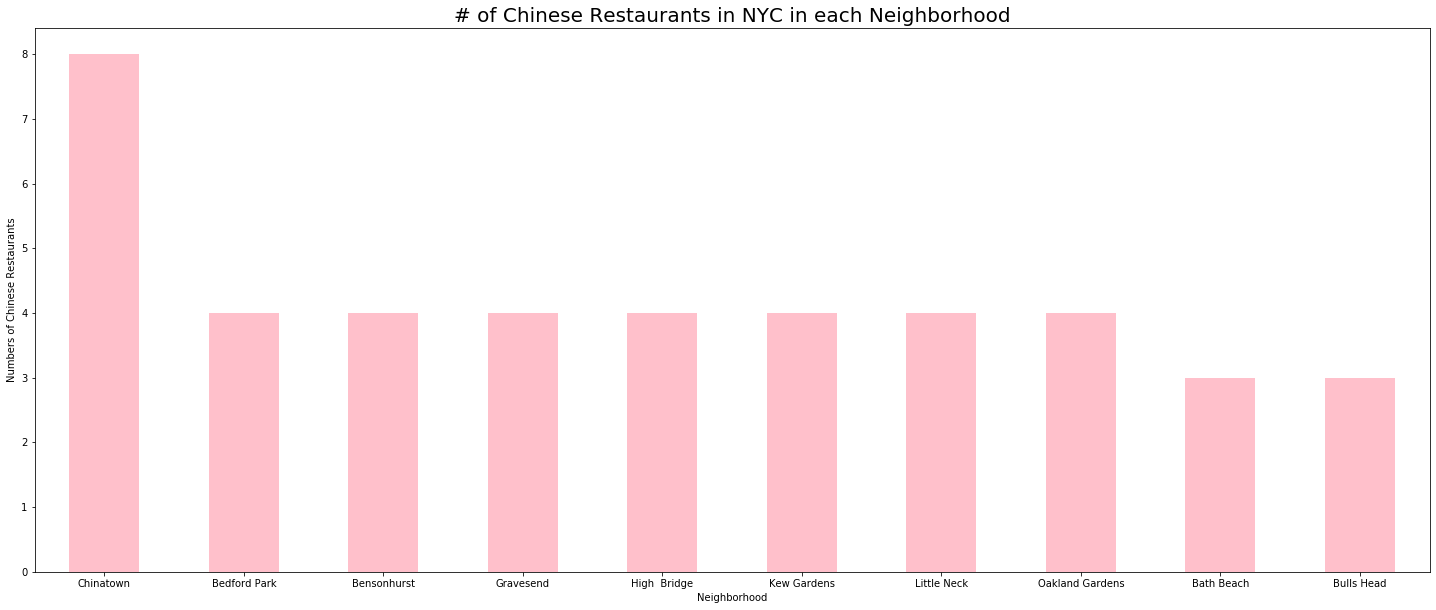

In [25]:
chi_rest_nyc.groupby('Neighborhood')['ID'].count().nlargest(10).plot.bar(figsize=(25,10), color ='pink')
plt.title('# of Chinese Restaurants in NYC in each Neighborhood',fontsize = 20)
plt.xlabel('Neighborhood')
plt.ylabel('Numbers of Chinese Restaurants')
plt.xticks(rotation = 'horizontal')
plt.show()

In [26]:
print(chi_rest_nyc.groupby('Neighborhood')['ID'].count().nlargest(10))

Neighborhood
Chinatown          8
Bedford Park       4
Bensonhurst        4
Gravesend          4
High  Bridge       4
Kew Gardens        4
Little Neck        4
Oakland Gardens    4
Bath Beach         3
Bulls Head         3
Name: ID, dtype: int64


In [27]:
# define the dataframe columns
column_names=['Borough', 'Neighborhood','ID', 'Name','Rating']
# instantiate the dataframe
chi_rest_ratings = pd.DataFrame(columns=column_names)

In [29]:
count=1
for Borough,Neighborhood,Latitude, Longitude, ID, Name in chi_rest_nyc.values.tolist():
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,rating = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,rating =[0]*3
    chi_rest_ratings=chi_rest_ratings.append({'Borough': Borough,
                                              'Neighborhood': Neighborhood, 
                                              'ID': id,
                                              'Name' : name,
                                              'Rating' : rating,
                                               }, ignore_index=True)
    count+=1
chi_rest_ratings.tail()

{'code': 200, 'requestId': '605900da134b3f1b4cb1551d'}
                         Id                          Name  Rating
0  4dabc3dc93a04642f09ccabd  Xing Lung Chinese Restaurant     6.7
{'code': 200, 'requestId': '605900da5002b329eee6a177'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4e3b11c98877b00cfc27a483
{'code': 200, 'requestId': '605900dafa1e3a7b4ba88e62'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4e41d2c4b61ca5ba3b1f9c6b
{'code': 200, 'requestId': '605900dbba191f1b4c352b6e'}
                         Id                        Name  Rating
0  4b9d6b45f964a52078ab36e3  Mr. Q's Chinese Restaurant     7.2
{'code': 200, 'requestId': '605900dbd0dfc02925160f5d'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4bc8f646b6c49c74d8898d91
{'code': 200, 'requestId': '605900dbee5d47164c2dd07e'}
                         Id                          Name  Rating
0  4e4d0387bd413c4cc66dfd72  

{'code': 200, 'requestId': '605900e536cfef7d45306ab3'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4c30c43816adc928519cbf9c
{'code': 200, 'requestId': '605900e5591ffa0514c2abbf'}
                         Id          Name  Rating
0  54ce8283498ea0f009041f78  Charisma Bay     6.6
{'code': 200, 'requestId': '605900e59e281b368f133bc9'}
                         Id                      Name  Rating
0  4d991e93af3d236a43f24cc7  Happy Seafood Restaurant     6.3
{'code': 200, 'requestId': '605900e6fa1e3a7b4ba8ab6c'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4c993e549c663704a6794efd
{'code': 200, 'requestId': '605900e65002b329eee6bf84'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4c5075d73940be9ae2124a07
{'code': 200, 'requestId': '605900e6c87eac3681871dcc'}
                         Id     Name  Rating
0  4a71ff01f964a52016da1fe3  Kum Kau     7.8
{'code': 200, 'requestId': '605900e67758a

{'code': 200, 'requestId': '605900f1b679c9171780f922'}
                         Id                               Name  Rating
0  4a96bf8ff964a520ce2620e3  Wah Fung Number 1 Fast Food 華豐快餐店     8.4
{'code': 200, 'requestId': '605900f1c9a53b29223ae78f'}
                         Id   Name  Rating
0  526eeb54498e9674b5d9034a  Decoy     9.1
{'code': 200, 'requestId': '605900f2e5172d5ab96c6782'}
                         Id     Name  Rating
0  4e1df590b61c7cb34d9735a8  RedFarm     8.9
{'code': 200, 'requestId': '605900f2c9a53b29223ae879'}
                         Id         Name  Rating
0  5742850f498e0114292c6a52  Ningbo Cafe     7.0
{'code': 200, 'requestId': '605900f25746a05180f99d1b'}
                         Id                Name  Rating
0  4ae1d8b2f964a520e78721e3  Peking BBQ Chicken     8.1
{'code': 200, 'requestId': '605900f2e920ac47533ee0ce'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4ad3bad9f964a520fce520e3
{'code': 200, 'requestId': '605900f29

{'code': 200, 'requestId': '605900fbe659e13ad326593b'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4c23d8b1f7ced13a6ce0216d
{'code': 200, 'requestId': '605900fbbb75427f38425fb5'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4cf2e1107bf3b60c9320687f
{'code': 200, 'requestId': '605900fb43cf176311736e66'}
                         Id       Name  Rating
0  4e4e41e8bd4101d0d7a620e0  Magic Wok     7.8
{'code': 200, 'requestId': '605900fb2146bf2b1798a0b0'}
                         Id           Name  Rating
0  4eb9c26046906fa3574d411f  Lucky Cornaga     6.8
{'code': 200, 'requestId': '605900fbc91b9a022f44594f'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4e4e41e9bd4101d0d7a620eb
{'code': 200, 'requestId': '605900fbab19b256d619d355'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4d9bb050b8b2224b84908655
{'code': 200, 'requestId': '605900fcbb75427f38426169'}

{'code': 200, 'requestId': '60590105ab19b256d619ec1d'}
                         Id                          Name  Rating
0  4d28b924ebacb1f72efbf34f  Wing Hing Seafood Restaurant     7.0
{'code': 200, 'requestId': '60590105591ffa0514c2fe26'}
                         Id               Name  Rating
0  514645bae4b0238f38bcdbac  Season Restaurant     5.6
{'code': 200, 'requestId': '60590105646f093892734828'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4bb7d282b35776b0b83dc801
{'code': 200, 'requestId': '60590106dfe7d41ffb4f9127'}
                         Id            Name  Rating
0  4c3f7f2eda3dc928b8f6c5b9  Peking Kitchen     7.4
{'code': 200, 'requestId': '605901065002b329eee712b7'}
Empty DataFrame
Columns: [Id, Name, Rating]
Index: []
No data available for id= 4c7dbf7f10916dcba78e2a96
{'code': 200, 'requestId': '605901067758a16adfea180f'}
                         Id                           Name  Rating
0  4d965fd061a3a1cde4989a42  Lucky Star Chinese

,Borough,Neighborhood,ID,Name,Rating
211,Bronx,Allerton,0,0,0.0
212,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,7.4
213,Bronx,Kingsbridge Heights,0,0,0.0
214,Bronx,Kingsbridge Heights,0,0,0.0
215,Brooklyn,Erasmus,0,0,0.0


In [30]:
chi_rest_ratings.head()

,Borough,Neighborhood,ID,Name,Rating
0,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,6.7
1,Bronx,Kingsbridge,0,0,0.0
2,Bronx,Norwood,0,0,0.0
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,7.2
4,Bronx,Pelham Parkway,0,0,0.0


In [31]:
chi_rest_ratings.to_csv('chi_rest_ratings_NYC.csv')

In [32]:
chi_rest_ratings = pd.read_csv('chi_rest_ratings_NYC.csv', index_col=[0])

In [33]:
chi_rest_ratings.sort_values(by=['Rating'], ascending=False).head(10)

,Borough,Neighborhood,ID,Name,Rating
201,Manhattan,Flatiron,59035bc43d47912d4b97f3fc,Xi'an Famous Foods,9.1
96,Manhattan,Chelsea,44e9b421f964a520a5371fe3,Buddakan,9.1
105,Manhattan,West Village,526eeb54498e9674b5d9034a,Decoy,9.1
42,Brooklyn,Windsor Terrace,54e39b14498e9c646b42958e,East Wind Snack Shop,9.0
75,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp,9.0
103,Manhattan,Little Italy,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp,9.0
100,Manhattan,Lower East Side,5b380f649deb7d00399fdf9d,Kings County Imperial,8.9
60,Brooklyn,Downtown,5db3649a8d15ba00089b4e9b,Xi'an Famous Foods,8.9
93,Manhattan,Upper West Side,5529bfd8498ec6ce692d8015,Han Dynasty,8.9
106,Manhattan,West Village,4e1df590b61c7cb34d9735a8,RedFarm,8.9


In [34]:
chi_rest_ratings.groupby('Borough')['Rating'].mean().sort_values(ascending=False)

Borough
Manhattan        7.865000
Brooklyn         3.998246
Queens           3.523077
Bronx            2.250000
Staten Island    1.922222
Name: Rating, dtype: float64

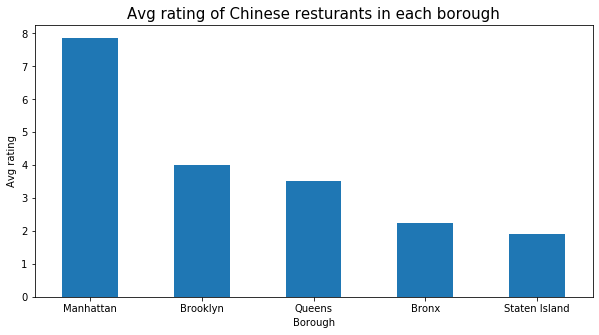

In [35]:
chi_rest_ratings.groupby('Borough')['Rating'].mean().sort_values(ascending=False).plot.bar(figsize=(10,5))
plt.title('Avg rating of Chinese resturants in each borough',fontsize = 15)
plt.xlabel('Borough')
plt.ylabel('Avg rating')
plt.xticks(rotation = 'horizontal')
plt.show()

In [36]:
avg_rating = chi_rest_ratings.groupby('Neighborhood')['Rating'].mean().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating': 'avg_rating'})
avg_rating.head(15)

,Neighborhood,avg_rating
0,Chelsea,9.100000
1,Flatiron,9.100000
2,West Village,9.000000
3,Windsor Terrace,9.000000
4,East Village,8.900000
5,Upper West Side,8.900000
6,North Side,8.900000
7,Murray Hill,8.800000
8,Little Italy,8.700000
9,Downtown,8.566667


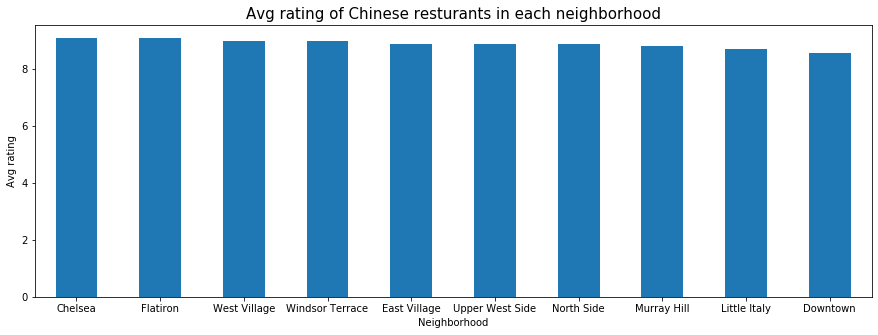

In [37]:
chi_rest_ratings.groupby('Neighborhood')['Rating'].mean().sort_values(ascending=False)[:10].plot.bar(figsize=(15,5))
plt.title('Avg rating of Chinese resturants in each neighborhood',fontsize = 15)
plt.xlabel('Neighborhood')
plt.ylabel('Avg rating')
plt.xticks(rotation = 'horizontal')
plt.show()

In [38]:
df1 = chi_rest_ratings.merge(avg_rating, on=['Neighborhood'])

In [39]:
df1 = df1[df1.avg_rating > 7.0]

In [40]:
df = chi_rest_nyc.merge(df1, on=['ID','Borough','Name','Neighborhood'])

In [41]:
df.head()

,Borough,Neighborhood,Latitude,Longitude,ID,Name,Rating,avg_rating
0,Bronx,Fordham,40.863001,-73.900894,566f33e7498e44c2501bda81,Panda Express,7.2,7.2
1,Bronx,Parkchester,40.836366,-73.853034,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,7.1,7.1
2,Bronx,Concourse,40.833933,-73.916674,4d9a695ee5fd6ea8e3096df5,Lucky House Chinese Restaurant,7.6,7.6
3,Brooklyn,Bay Ridge,40.625082,-74.030494,5553702c498ecb85f99d8f37,XIN,7.1,7.2
4,Brooklyn,Bay Ridge,40.622573,-74.028423,4a5beec3f964a52006bc1fe3,86 Noodles,7.3,7.2


In [69]:
 df.sort_values(['Borough','avg_rating'],ascending=False).groupby('Borough').head(4)

,Borough,Neighborhood,Latitude,Longitude,ID,Name,Rating,avg_rating,Label
52,Staten Island,Dongan Hills,40.585895,-74.092963,4bba73677421a593ebd4c340,Jac Mao,7.7,7.700000,"Dongan Hills, Staten Island(7.7)"
59,Staten Island,Manor Heights,40.604778,-74.121160,4be75c8f2468c928fc720243,Tack's Chinese Take Out,7.4,7.400000,"Manor Heights, Staten Island(7.4)"
48,Queens,Elmhurst,40.741339,-73.881330,56296f14498edb1ed77b64a3,Five Loaves and Two Fishes,8.1,8.250000,"Elmhurst, Queens(8.25)"
49,Queens,Elmhurst,40.741078,-73.879996,4eaf0752d3e30d448393b841,Lao Bei Fang,8.4,8.250000,"Elmhurst, Queens(8.25)"
50,Queens,Forest Hills,40.723596,-73.847968,4b68c90ff964a520da8c2be3,Great Wall Chinese Restaurant,7.9,7.900000,"Forest Hills, Queens(7.9)"
51,Queens,Rego Park,40.729334,-73.862956,4edac00e0aaf49e02a0e2f73,Tasty & Co,7.6,7.600000,"Rego Park, Queens(7.6)"
37,Manhattan,Chelsea,40.742120,-74.004612,44e9b421f964a520a5371fe3,Buddakan,9.1,9.100000,"Chelsea, Manhattan(9.1)"
56,Manhattan,Flatiron,40.740632,-73.987346,59035bc43d47912d4b97f3fc,Xi'an Famous Foods,9.1,9.100000,"Flatiron, Manhattan(9.1)"
46,Manhattan,West Village,40.734182,-74.006462,526eeb54498e9674b5d9034a,Decoy,9.1,9.000000,"West Village, Manhattan(9.0)"
47,Manhattan,West Village,40.734194,-74.006268,4e1df590b61c7cb34d9735a8,RedFarm,8.9,9.000000,"West Village, Manhattan(9.0)"


In [42]:
# create map of NYC
map_nyc = folium.Map(location=get_geo_locations('New York'), zoom_start=10)

# add markers to map
df['Label']=df['Neighborhood']+', '+df['Borough']+'('+df['avg_rating'].map(str)+')'
for lat, lng, label in zip(df['Latitude'],df['Longitude'],df['Label']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_nyc)
map_nyc

In [43]:
nyc_census = pd.read_csv('nyc_census.csv', index_col = False)

In [44]:
print(nyc_census.shape)
print(nyc_census.head())

(4410, 4)
      Neighborhood       Race/Ethnicity    Age Group Population
0  101 Kingsbridge  White, non-Hispanic  Less than 1        447
1  101 Kingsbridge  White, non-Hispanic       1-4 yr      1,477
2  101 Kingsbridge  White, non-Hispanic       5-9 yr      1,334
3  101 Kingsbridge  White, non-Hispanic     10-11 yr        475
4  101 Kingsbridge  White, non-Hispanic     12-14 yr        667


In [45]:
nyc_census.dtypes

Neighborhood      object
Race/Ethnicity    object
Age Group         object
Population        object
dtype: object

In [46]:
list(nyc_census.columns)

['Neighborhood', 'Race/Ethnicity', 'Age Group', 'Population']

In [47]:
nyc_census['Population'] = nyc_census['Population'].str.replace(',','').astype(int)

In [48]:
nyc_census['Age Group'].unique()

array(['Less than 1', '1-4 yr', '5-9 yr', '10-11 yr', '12-14 yr',
       '15-17 yr', '18-19 yr', '20-24 yr', '25-29 yr', '30-34 yr',
       '35-39 yr', '40-44 yr', '45-49 yr', '50-54 yr', '55-59 yr',
       '60-64 yr', '65-69 yr', '70-74 yr', '75-79 yr', '80-84 yr',
       '85+ yr'], dtype=object)

In [49]:
total = nyc_census.groupby('Race/Ethnicity')['Population'].sum().to_frame().reset_index().rename(columns={'Population':'total'})

In [50]:
total

,Race/Ethnicity,total
0,"Asian/Pacific Islander, non-Hispanic",1030914
1,"Black, non-Hispanic",1861279
2,Hispanic,2336070
3,"Other races, non-Hispanic",223943
4,"White, non-Hispanic",2722902


In [51]:
total_by_nei = nyc_census.groupby(['Neighborhood','Race/Ethnicity'])['Population'].sum().to_frame().reset_index()

In [52]:
total_by_nei.head()

,Neighborhood,Race/Ethnicity,Population
0,101 Kingsbridge,"Asian/Pacific Islander, non-Hispanic",4228
1,101 Kingsbridge,"Black, non-Hispanic",10120
2,101 Kingsbridge,Hispanic,36184
3,101 Kingsbridge,"Other races, non-Hispanic",1734
4,101 Kingsbridge,"White, non-Hispanic",38626


In [53]:
total_all = total_by_nei.merge(total,on='Race/Ethnicity')

In [54]:
total_all['avg']=total_all['Population']/total_all['total']
total_all.head()

,Neighborhood,Race/Ethnicity,Population,total,avg
0,101 Kingsbridge,"Asian/Pacific Islander, non-Hispanic",4228,1030914,0.004101
1,102 Northeast Bronx,"Asian/Pacific Islander, non-Hispanic",5288,1030914,0.005129
2,103 Fordham - Bronx Pk,"Asian/Pacific Islander, non-Hispanic",12588,1030914,0.012211
3,104 Pelham,"Asian/Pacific Islander, non-Hispanic",19677,1030914,0.019087
4,105 Crotona-Tremont,"Asian/Pacific Islander, non-Hispanic",2775,1030914,0.002692


In [55]:
total_all[total_all['Race/Ethnicity']=='Asian/Pacific Islander, non-Hispanic'].sort_values(['avg'],ascending = (False)).head(20)

,Neighborhood,Race/Ethnicity,Population,total,avg
30,403 Flushing,"Asian/Pacific Islander, non-Hispanic",125752,1030914,0.121981
29,402 West Queens,"Asian/Pacific Islander, non-Hispanic",117863,1030914,0.114329
12,206 Borough Park,"Asian/Pacific Islander, non-Hispanic",66519,1030914,0.064524
26,309 Union Square,"Asian/Pacific Islander, non-Hispanic",54087,1030914,0.052465
34,407 SouthWest Queens,"Asian/Pacific Islander, non-Hispanic",53803,1030914,0.052190
15,209 Bensonhurst,"Asian/Pacific Islander, non-Hispanic",46677,1030914,0.045277
11,205 Sunset Park,"Asian/Pacific Islander, non-Hispanic",45707,1030914,0.044336
16,210 Coney Island,"Asian/Pacific Islander, non-Hispanic",44045,1030914,0.042724
35,408 Jamaica,"Asian/Pacific Islander, non-Hispanic",42054,1030914,0.040793
32,405 Ridgewood,"Asian/Pacific Islander, non-Hispanic",37974,1030914,0.036835


In [71]:
total_all.groupby('Neighborhood')['Population'].sum().to_frame().sort_values(['Population'],ascending = (False)).head(20)

,Population
Neighborhood,
402 West Queens,480501
206 Borough Park,331983
203 Bed-Stuy,318898
104 Pelham,297927
207 Flatbush,296583
408 Jamaica,289314
210 Coney Island,285502
407 SouthWest Queens,266265
403 Flushing,259767


### Conclusion

#### 1. Where can you go in NYC to have the best Chinese food?

If you are in NYC and you are craving for some tasty Chinese food, Manhattan is your best bet. You can head to Chelsea, Flatiron or West Village. You should head to Chinatown if you want to have more selections since Chinatown has more higher rating Chinese restaurants in its neighborhood.
_______________________________________________________

#### 2. Which neighborhood can you go in the borough you live to find the best Chinese food?

In Staten Island, you can head to Dongan Hills or Manor Heights.\
In Queens, you can head to Elmhurst, Forest Hills or Rego Park.\
In Manhattan, you can head to Chelsea, Flatiron or West Village.\
In Brooklyn, you can head to Windsor Terrace,North Side or Downtown.\
In Bronx, you can head to Concourse, Bronxdale, Fordham or Parkchester.
_______________________________________________________


#### 3. Which neighborhood in NYC will be the best choice to open a new Chinese restaurant?

West Queens would be the best choice to start a Chinese restaurant since it has the top population of 480,501 by region among all NYC neighborhoods and it has the second highest Asian/Pacific Islander, non-Hispanic population by region in NYC. Furthermore, although Queens has the most Chinese restaurants by volume, the rating compared to Manhattan is much lower so there's definitely opportunities to penetrate the market there through quality and elevated experiences.
